<a href="https://colab.research.google.com/github/m4xig1/DisasterTweets/blob/main/Disaster_Tweets_Kaggle_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Хочу попробовать использовать градиентный бустинг над более простыми моделями, завершим fine-tune'm LLM типо BERT

In [ ]:
import numpy as np
import pandas as pd
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
# upload zip file
!unzip nlp-getting-started.zip -d data

Archive:  nlp-getting-started.zip
replace data/sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
train_df = pd.read_csv("/content/data/train.csv")
test_df = pd.read_csv("/content/data/test.csv")

In [ ]:
train_df.head() # checking if data uploaded correctly

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


*Accuracy = $\frac{TP + TN}{TP + FP + TN + FN}$* can be quite sensetive for class disbanace, so we need to check it.

<Axes: ylabel='Frequency'>

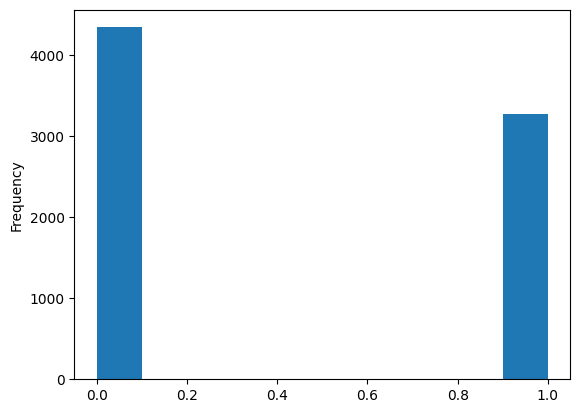

In [ ]:
train_df['target'].plot.hist()

#Preprocessing

In [ ]:
import string
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords

In [ ]:
def my_tokenizer(sentence):
    sent = [x.lower() for x in sent_tokenize(sentence) if x not in string.punctuation and x not in stopwords.words('english')] # and x not in stopwords
    return " ".join(sent)

In [ ]:
train_df['tokenized'] = train_df['text'].apply(my_tokenizer)
test_df['tokenized'] = test_df['text'].apply(my_tokenizer)
train_df.head()

Now we need to get embadding of the sentence, there's quite a big field for experement, this time I'll use sbert a.k.a. [Sentence-BERT](https://sbert.net)

(примеры других эмбеддингов см. [тут](https://habr.com/ru/articles/515036/))

In [ ]:
!pip install -U sentence-transformers

In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')

In [ ]:
train_df['embaddings'] = train_df["tokenized"].apply(model.encode) # this can take a while
test_df['embaddings'] = test_df["tokenized"].apply(model.encode) # ОСОБЕННО КОГДА У ТЕБЯ A100 ОТОБРАЛИ
train_df.head()

#CatBoost


Catboost can work with categorial features so we don't need to preprocess anything (mby we don't want to use them because of big number of unique and NaN values -- it can cause overtraining)

In [ ]:
# train_df['keyword'].unique()
len(train_df['location'].unique())

In [ ]:
!pip install catboost
from catboost import CatBoostClassifier

In [ ]:
X = train_df['embaddings'].to_list()
y = train_df['target'].to_list()

In [ ]:
from sklearn.metrics import accuracy_score
# for n in tqdm([1, 10, 50, 100, 150, 200, 250]): # подбор гиперпараметра, что еще подбирать -- хз
#     model = CatBoostClassifier(n_estimators=n, eval_metric='Accuracy', task_type='GPU')
#     model.fit(X, y)
#     ans = model.predict(X)
#     train_acc = accuracy_score(y, ans)
#     print(f"Accuracy with {n} estimators is: {train_acc}")

In [ ]:
 model = CatBoostClassifier(n_estimators=250, eval_metric='Accuracy', task_type='GPU')
 model.fit(X, y)

In [ ]:
test_df['target'] = test_df['embaddings'].apply(model.predict)

In [ ]:
test_df.to_csv('./ans.csv', columns = ['id', 'target'], index=False)

Now we have pretty good score: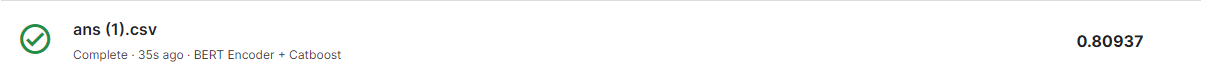

#LLM


Now I'll to beat my baseline (not really) model using pretrained BERT

In [ ]:
!pip install transformers -U
!pip install transformers[torch]
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 51.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 126.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 82.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 4.7 MB/s eta 0:00:00


In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased') # i think we need to tokenize text again

model = BertForSequenceClassification.from_pretrained('bert-base-uncased')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.to(device)
device

'cuda'

In [ ]:
train_df = pd.read_csv("/content/data/train.csv")
test_df = pd.read_csv("/content/data/test.csv")

In [ ]:
X = list(train_df['text'])
y = list(train_df['target'])

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.15, stratify=y)

In [ ]:
X_train_embaddings = tokenizer(X_train, max_length=512, padding = "max_length")
X_val_embaddings = tokenizer(X_val, max_length=512, padding = "max_length")

In [ ]:
class Dataset(torch.utils.data.Dataset):
    """
    Custom PyTorch Dataset for handling input encodings and labels.

    Args:
        encodings (dict): A dictionary containing the input encodings (e.g., input_ids, attention_mask).
        labels (list, optional): List of labels corresponding to each input. Set to None for inference.

    Returns:
        item (dict): A dictionary containing the tensors for each input encoding and labels (if provided).
    """

    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        """
        Get an item from the dataset at the specified index.

        Args:
            idx (int): Index of the item to retrieve.

        Returns:
            item (dict): A dictionary containing the tensors for each input encoding and labels (if provided).
        """
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        """
        Get the total number of samples in the dataset.

        Returns:
            int: Total number of samples in the dataset.
        """
        return len(self.encodings["input_ids"])

In [ ]:
train_dataset = Dataset(X_train_embaddings, y_train)
val_dataset = Dataset(X_val_embaddings, y_val)

In [ ]:
from transformers import TrainingArguments, Trainer # первый раз это использую, вроде как говорят, что экономит много строк кода
from sklearn.metrics import accuracy_score, f1_score

def calc_metrics(v):
    predicted, labels = v
    predicted = np.argmax(predicted, axis=1) # binary
    return f"Accuracy: {accuracy_score(labels, predicted)}, F1-score: {f1_score(labels, predicted)}"

In [ ]:
args = TrainingArguments(output_dir='./123', num_train_epochs=5) # тут с числом эпох не разгуляешься...

trainer = Trainer(model=model, train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=calc_metrics,
    args = args)

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
500,0.513200
1000,0.481400
1500,0.419000
2000,0.350700
2500,0.340800
3000,0.260000
3500,0.191800
4000,0.197000


TrainOutput(global_step=4045, training_loss=0.3425584757725889, metrics={'train_runtime': 2881.2793, 'train_samples_per_second': 11.229, 'train_steps_per_second': 1.404, 'total_flos': 8512958196172800.0, 'train_loss': 0.3425584757725889, 'epoch': 5.0})

In [ ]:
temp = []
for ind, row in test_df.iterrows():
    text = row['text']
    token = tokenizer(text, padding=True, truncation=True, return_tensors='pt').to(device)
    pred = model(**token)

    logits = pred.logits # predicted probability
    ans = torch.nn.functional.softmax(logits, dim=-1)

    predicted_label = torch.argmax(ans, dim=-1).item()
    temp.append(predicted_label)

df = pd.DataFrame({'id': test_df['id'], 'target': temp})

In [ ]:
df.to_csv("/content/data/submission.csv", index=False)

Pretty solid result (top 15%) 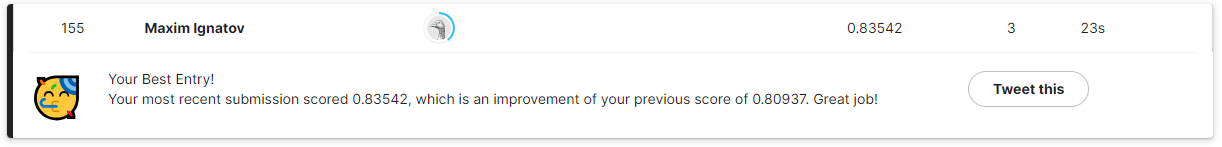


# More unsolved problems and suggestions


* Twitter is a place where people can use different slang, unformal grammar and links so for pretrained model it can be quite difficult to understand it, but we can resolve it by cleaning dataset (like in this [paper](https://arxiv.org/pdf/2202.00795.pdf))
* We can use hyperparameter fine tune (grid-search) to slightly increase accuracy
* Try different embaddings for Catboost model
* Try F1-score for learning
* Use more epochs to fine-tune BERT
